In [1]:
import torch
from torchvision import transforms, models
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
image_paths=[]
for dirname, _, filenames in os.walk('/kaggle/input/ham1000-segmentation-and-classification/images'):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            image_paths.append(os.path.join(dirname, filename))

In [3]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [4]:


class SkinDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

dataset = SkinDataset(image_paths, transform=transform)
print(len(dataset))

10015


In [5]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

In [6]:
model = models.mobilenet_v2(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove classification head
model = model.to(device).eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s] 


In [7]:
def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():  # Disable gradients for faster computation
        for batch in tqdm(dataloader, desc="Calculating Embeddings"):
            images = batch.to(device)  # Move batch to GPU
            with torch.cuda.amp.autocast():  # Mixed precision for faster computation
                batch_embeddings = model(images).squeeze()  # Get embeddings for the batch
            embeddings.append(batch_embeddings.cpu().numpy())  # Move to CPU and convert to numpy
    return np.vstack(embeddings)  # Combine all embeddings into a single NumPy array

# Step 3: Use DataLoader to Calculate Embeddings
# Assuming your dataloader is already defined
# Example: dataloader = DataLoader(your_dataset, batch_size=64, shuffle=False)

embeddings = extract_embeddings(dataloader)  # Get embeddings for all images
print(f"Embeddings calculated: {embeddings.shape}")
np.save("embeddings.npy", embeddings)  # Save embeddings to disk
print("Embeddings saved successfully.")

Calculating Embeddings:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_23/3403094436.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision for faster computation
Calculating Embeddings: 100%|██████████| 79/79 [02:30<00:00,  1.90s/it]


Embeddings calculated: (10015, 1280, 7, 7)
Embeddings saved successfully.


In [10]:
np.save("/kaggle/working/embeddings.npy", embeddings)  # Save embeddings to disk
print("Embeddings saved successfully.")

Embeddings saved successfully.


In [16]:
SIMILARITY_THRESHOLD = 0.93

# embeddings on GPU and reshape 
embeddings_tensor = torch.tensor(embeddings, device="cuda")  
embeddings_tensor = torch.mean(embeddings_tensor, dim=(2, 3))  # Dim Reduction -> Shape: (num_images, embedding_dim)

# Normalize
norms = torch.norm(embeddings_tensor, dim=1, keepdim=True) 
normalized_embeddings = embeddings_tensor / norms  # Shape: (num_images, embedding_dim)
print(f"normalized_embeddings shape: {normalized_embeddings.shape}")
print(f"normalized_embeddings.T shape: {normalized_embeddings.T.shape}")


to_remove = set()
num_embeddings = normalized_embeddings.shape[0]

# Perform pairwise similarity checks
print("Starting pairwise similarity computation...")
for i in tqdm(range(num_embeddings), desc="Removing duplicates"):
    if i in to_remove:
        continue

    # Compute cosine similarity for the i-th embedding with all others
    similarities = torch.matmul(normalized_embeddings[i:i+1], normalized_embeddings.T).squeeze(0)
    
    # Find indices where similarity exceeds the threshold
    similar_indices = torch.where(similarities > SIMILARITY_THRESHOLD)[0].tolist()

    # Exclude self-match and mark duplicates for removal
    for j in similar_indices:
        if j > i:  # Ensure we only mark duplicates after i
            to_remove.add(j)

# Move indices to CPU
to_remove = list(to_remove)

remaining_indices = [idx for idx in range(num_embeddings) if idx not in to_remove]
remaining_embeddings = normalized_embeddings[remaining_indices].cpu().numpy()
remaining_paths = [image_paths[idx] for idx in remaining_indices]
removed_paths = [image_paths[idx] for idx in to_remove]


with open("/kaggle/working/removed_images.txt", "w") as f:
    for path in removed_paths:
        f.write(path + "\n")

with open("/kaggle/working/remaining_image_paths.txt", "w") as f:
    for path in remaining_paths:
        f.write(path + "\n")

print(f"Finished processing. Removed {len(to_remove)} duplicates. Remaining: {len(remaining_paths)} images.")

normalized_embeddings shape: torch.Size([10015, 1280])
normalized_embeddings.T shape: torch.Size([1280, 10015])
Starting pairwise similarity computation...


Removing duplicates: 100%|██████████| 10015/10015 [00:01<00:00, 5587.67it/s]


Finished processing. Removed 1556 duplicates. Remaining: 8459 images.


Found 19 pairs with similarity threshold = 0.95.


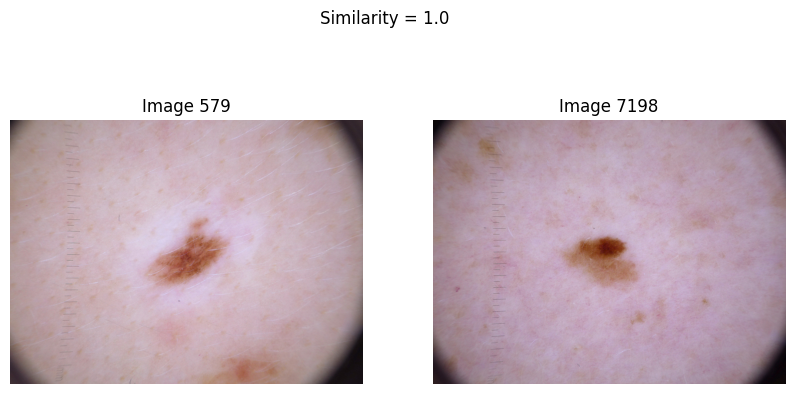

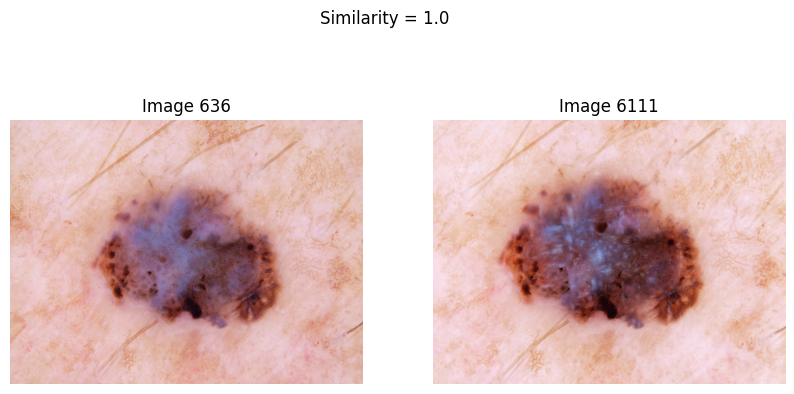

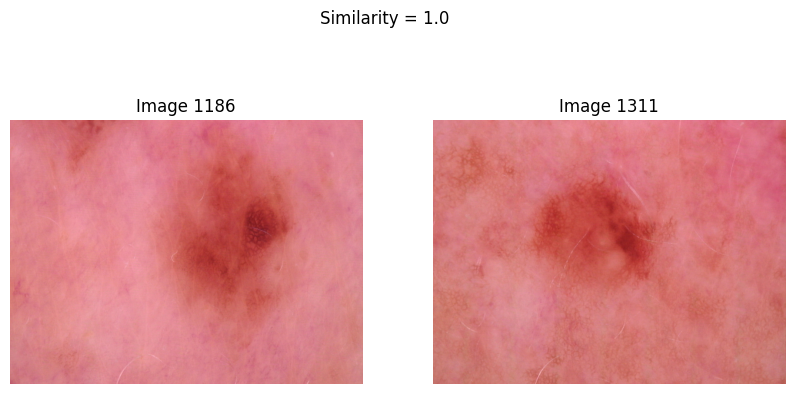

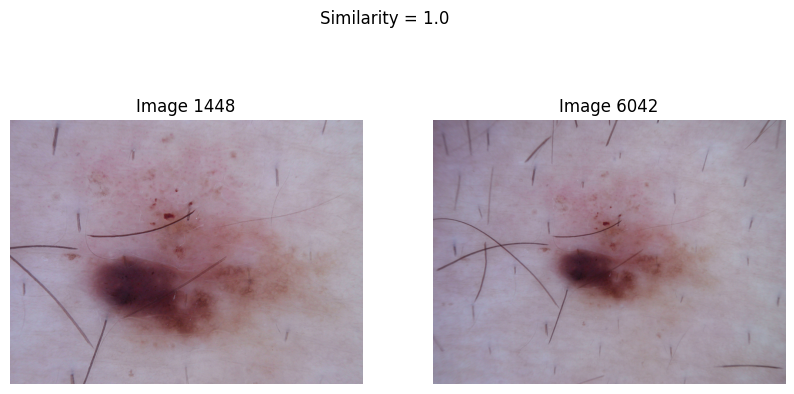

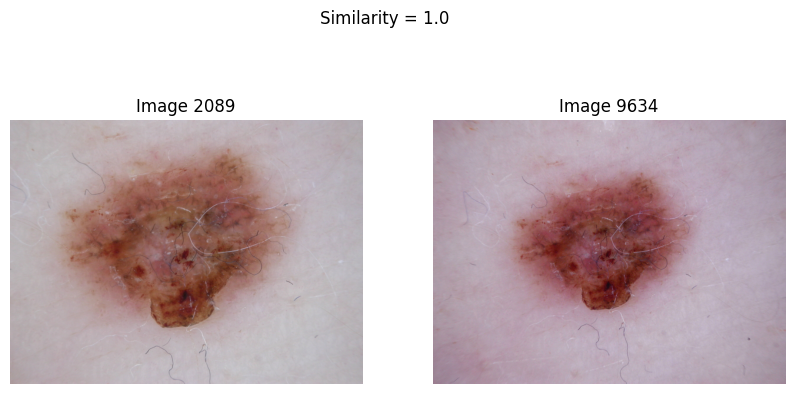

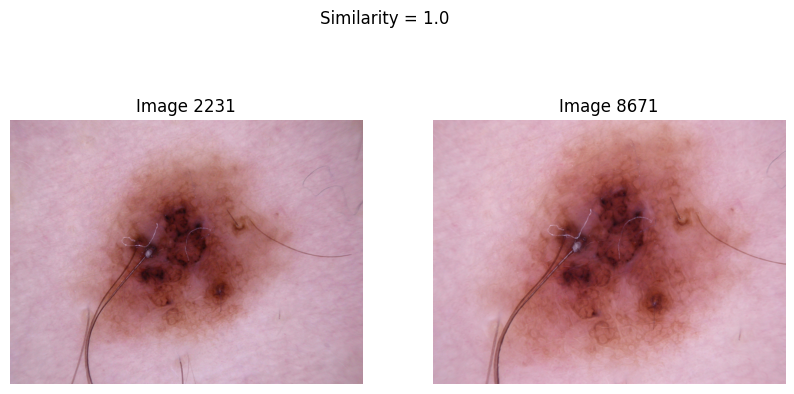

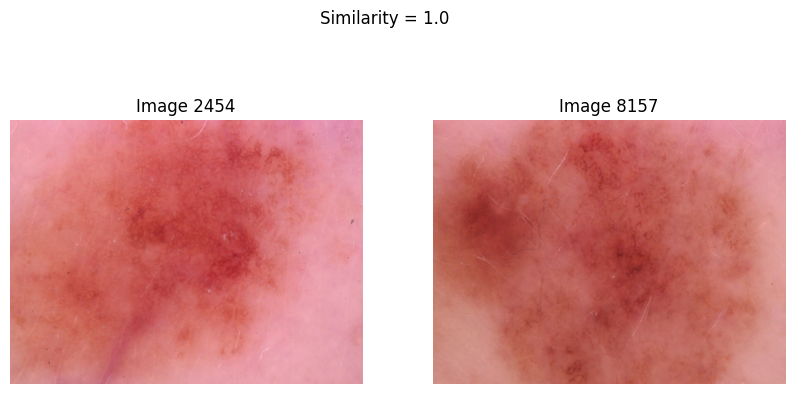

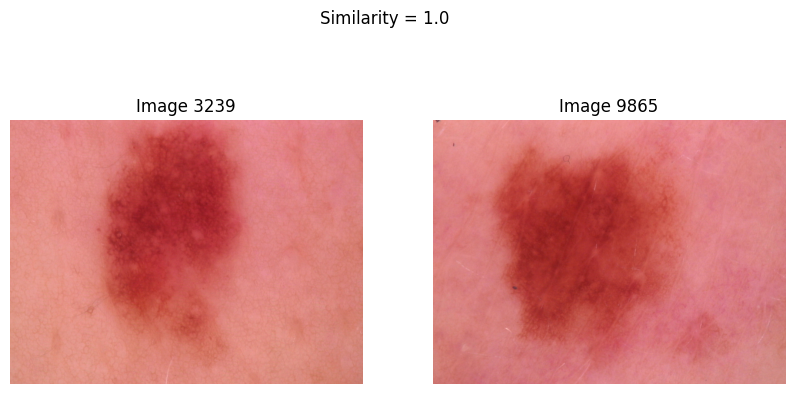

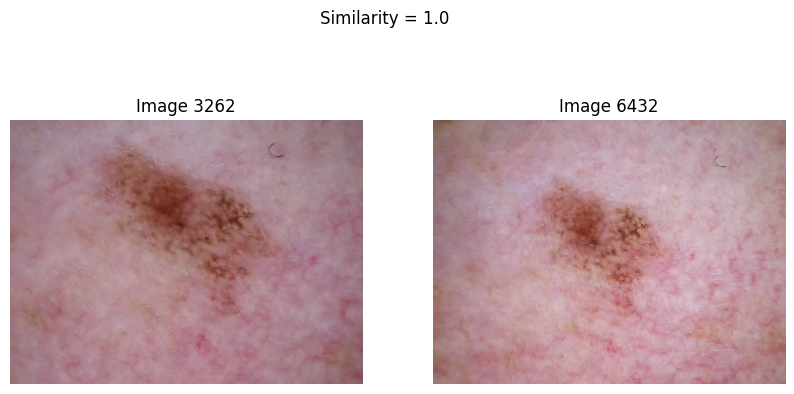

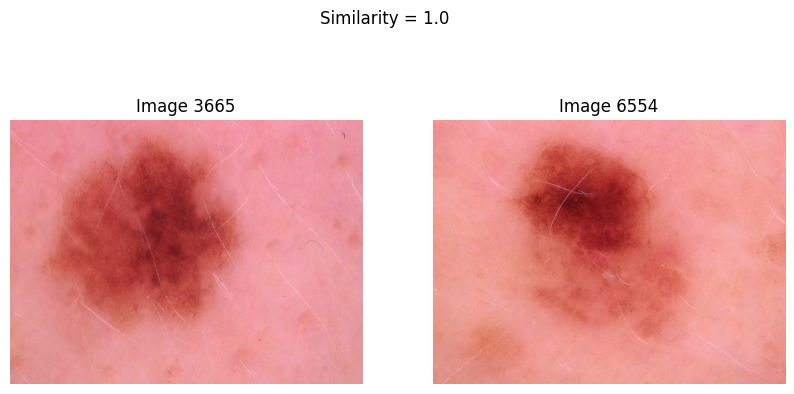

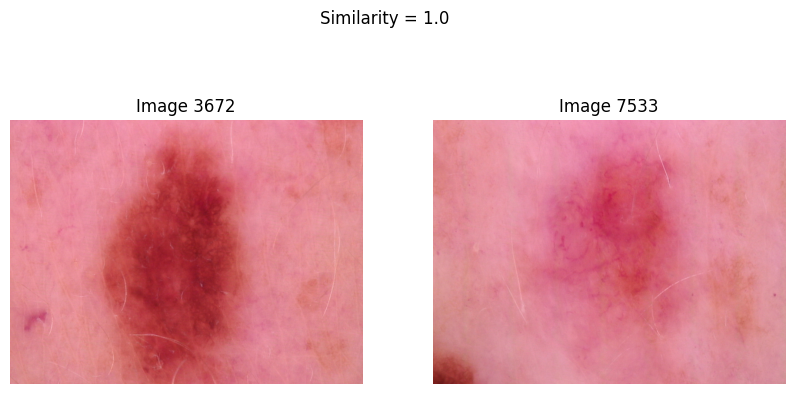

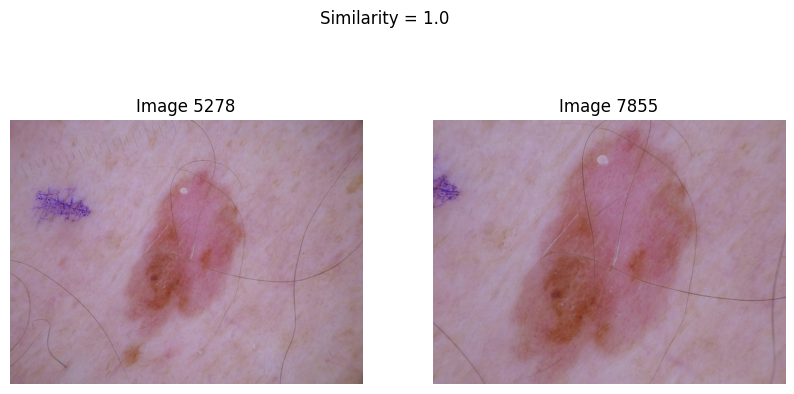

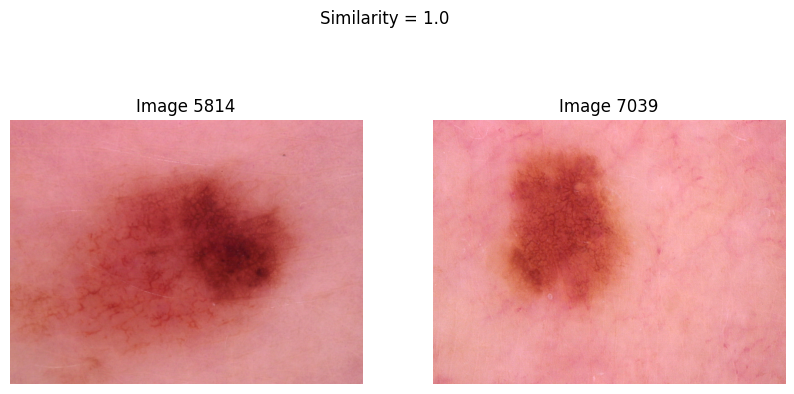

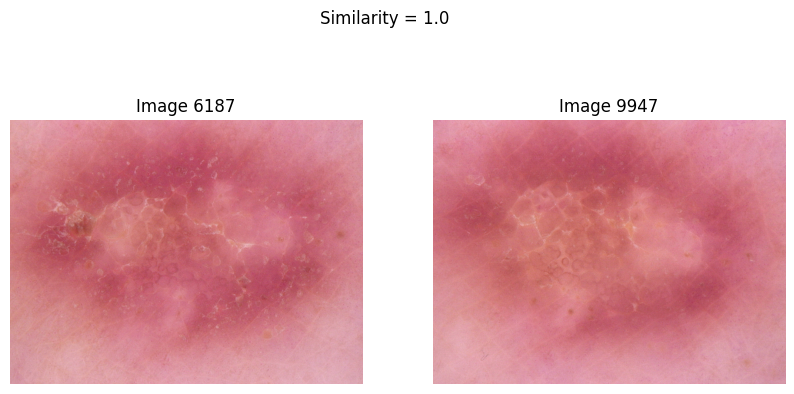

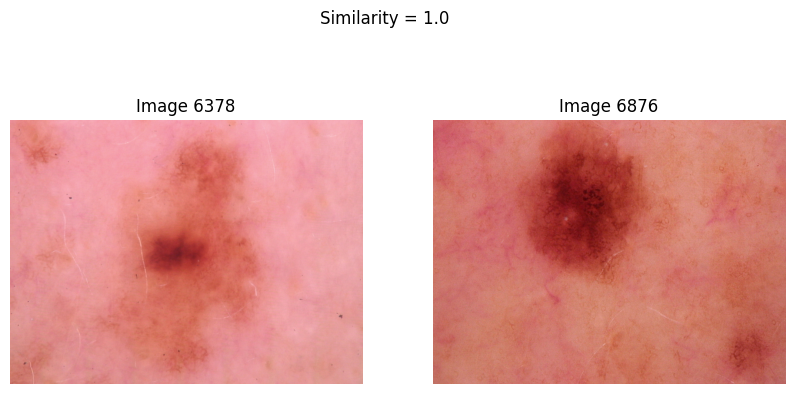

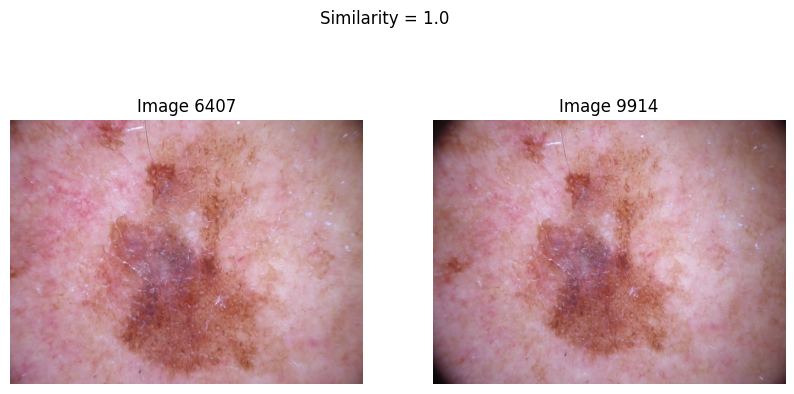

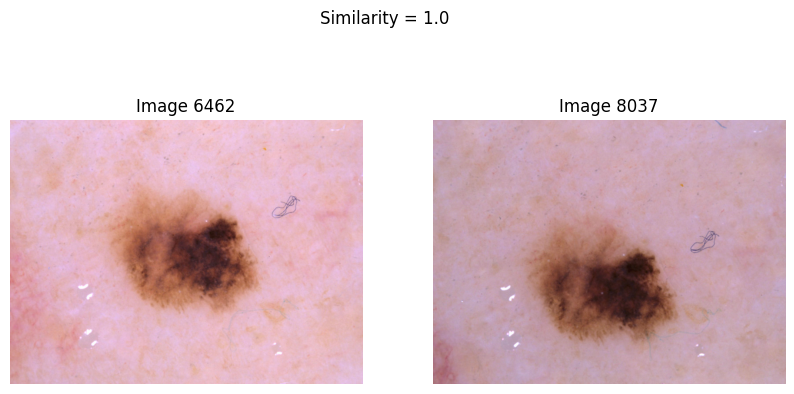

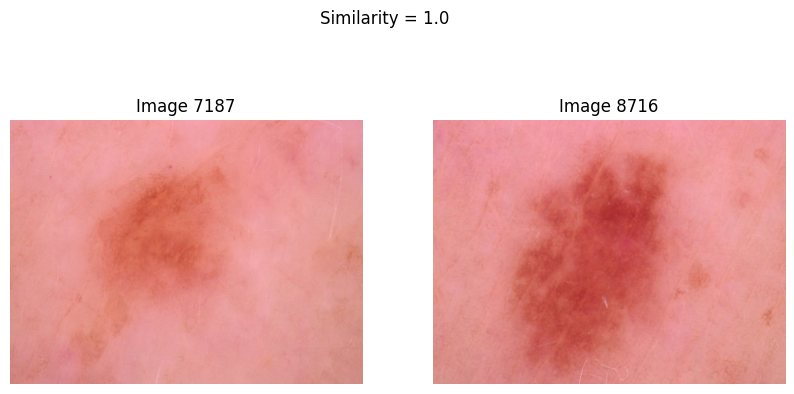

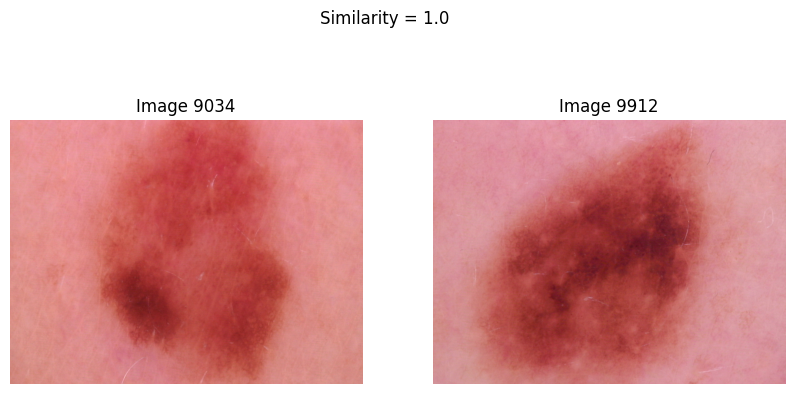

In [15]:

import matplotlib.pyplot as plt
from PIL import Image

SIMILARITY_THRESHOLD = 0.95

# Example embeddings and paths for illustration
embeddings_tensor = torch.tensor(embeddings, device="cuda")
embeddings_tensor = torch.mean(embeddings_tensor, dim=(2, 3))  # Dim Reduction -> Shape: (num_images, embedding_dim)

# Normalize
norms = torch.norm(embeddings_tensor, dim=1, keepdim=True) 
normalized_embeddings = embeddings_tensor / norms

# Compute cosine similarity matrix
similarity_matrix = torch.matmul(normalized_embeddings, normalized_embeddings.T)

# Find pairs with similarity exactly equal to 1
similar_pairs = torch.where(similarity_matrix == SIMILARITY_THRESHOLD)
similar_indices = [(i.item(), j.item()) for i, j in zip(*similar_pairs) if i != j and i < j]

print(f"Found {len(similar_indices)} pairs with similarity threshold = {SIMILARITY_THRESHOLD}.")

# Display the similar images side by side
for idx1, idx2 in similar_indices:
    image1_path = image_paths[idx1]
    image2_path = image_paths[idx2]

    # Load images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title(f"Image {idx1}")

    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title(f"Image {idx2}")

    plt.suptitle(f"Similarity = 1.0")
    plt.show()
